In [11]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

root_dir = Path('/content/gdrive/MyDrive/Data')

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math
from tensorflow.keras import layers
import torch
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics
tf.random.set_seed(42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
def rotate_and_reverse(arr):
  arr_rotated = np.rot90(arr)
  return arr_rotated[::-1]

def chunk_up_psg(psg_df, freq=100):
  res = []
  for i in range(int(psg_df.shape[0]/(freq*30))):
    chunk = np.array(psg_df.iloc[i*freq*30:(i+1)*freq*30])
    chunk_rotated = rotate_and_reverse(chunk).reshape(-1)
    #print(chunk_rotated.shape)
    res.append(chunk_rotated)
  return np.array(res)

def downsample_data(data, rate=10):
  res = []
  for i in range(data.shape[0]):
    arr = np.zeros(int(data.shape[1]/rate))
    for j in range(int(data.shape[1]/rate)):
      arr[j] = torch.mean(data[i][j * rate : (j + 1) * rate])
    res.append(arr)
  return torch.from_numpy(np.array(res))

def get_N1_class_label(annot_df, label_map):
  all_labels = np.zeros(annot_df.shape[0])
  res = []
  #n = len(label_map.keys())
  n = 5
  for i in range(annot_df.shape[0]):
    N1_label = label_map[annot_df.iloc[i,0]]
    all_labels[i] = N1_label
    labels = []
    for i in range(n):
      label = np.array([0, 1])
      if i == N1_label:
        label = np.array([1, 0])
      labels.append(label)
    res.append(np.array(labels))
    #label[N1_label] = 1
  return np.array(res), all_labels

def get_class_ids(annot_df, subject):
  return annot_df.index[annot_df['labels'] == subject].tolist()

def get_subject_psgs(psgs, annot_df, subject):
  indices = torch.tensor(get_class_ids(annot_df, subject))
  psg_subject = torch.index_select(psgs, 0, indices)
  return psg_subject

def gaussian_noise(data):
  mean, std = 0, torch.std(data) * 10 #torch.mean(data),
  noise = torch.tensor(np.random.normal(0, std)) #np.random.normal(mean, std, data.size()), dtype=torch.float32)
  return data + noise

def perm(data):
  permutation = random.sample(range(0, data.shape[1]), data.shape[1])
  return data[:, permutation]

def fft(data):
  return torch.fft.fft(data)

def augment_dataset(dataset, noise_times = 1):
  res = torch.cat((dataset, perm(dataset), fft(dataset), gaussian_noise(dataset)), 0)
  for i in range(1, noise_times):
    res = torch.cat((res, gaussian_noise(dataset)), 0)
  return res

def augment_all_subject(psgs, annot_df, label_map, noise_times=1):
  res_dataset, res_labels = None, None
  i = 0
  for subject, label in label_map.items():
    if i == 1:
      break
    i +=1
    dataset_subject = get_subject_psgs(psgs, annot_df, subject)
    augmented_subject_dataset = augment_dataset(dataset_subject, noise_times = noise_times)

    subject_labels = torch.full((dataset_subject.shape[0],), 0)
    subject_labels = torch.cat((subject_labels, torch.full((dataset_subject.shape[0],), 1)), dim=0)
    subject_labels = torch.cat((subject_labels, torch.full((dataset_subject.shape[0],), 2)), dim=0)
    subject_labels = torch.cat((subject_labels, torch.full((dataset_subject.shape[0]*noise_times,), 3)), dim=0)
    print(f"{subject}: mean = {torch.mean(dataset_subject):.5f}, std = {torch.std(dataset_subject):.5f}")

    if res_dataset == None:
      res_dataset = augmented_subject_dataset
      res_labels = subject_labels
    else:
      res_dataset = torch.cat((res_dataset, augmented_subject_dataset), dim=0)
      res_labels = torch.cat((res_labels, subject_labels), dim=0)
    res_dataset = res_dataset.type(torch.float32)
  return res_dataset, res_labels

def train_test_split(data, train=0.8, validation=0.1, test=0.1):
  data_len = data.shape[0]
  train_split = int(data_len * train)
  validation_split = int(data_len * (train + validation))
  return data[:train_split], data[train_split:validation_split], data[validation_split:]

def epochize_training_data(training_data, EPOCHS=32):
  res = []
  for i in range(math.ceil(training_data.shape[0]/EPOCHS)):
    epoch_chunk = training_data[i * EPOCHS: (i+1) * EPOCHS]
    res.append(epoch_chunk)
  return res

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

In [13]:
save_psg = root_dir / Path("Sleep EDF Data/Processed/PSG.pkl")
save_annot = root_dir / Path("Sleep EDF Data/Processed/Annot.pkl")

psg_df = pd.read_pickle(save_psg)
annot_df = pd.read_pickle(save_annot)
psg_df.shape, annot_df.shape

psgs_orig = torch.from_numpy(chunk_up_psg(psg_df))
#psgs_orig = downsample_data(psgs_orig, 1)

psgs_orig.shape
psgs = psgs_orig * 1000000
#psgs = torch.round(psgs, decimals=3)
#psgs = psgs + 0.5

label_map = {'Sleep stage 1': 0,
            'Sleep stage 2': 1,
            'Sleep stage 3': 2,
            'Sleep stage 4': 2,
            'Sleep stage R': 3,
            'Movement time': 4,
            'Sleep stage W': 4}

N1_class_annot, all_labels = get_N1_class_label(annot_df, label_map)
N1_class_annot.shape, N1_class_annot[:10]

psgs_N1 = get_subject_psgs(psgs, annot_df, 'Sleep stage 1')

label_map = {'Sleep stage 1': 0,
            'Sleep stage 2': 1,
            'Sleep stage 3': 2,
            'Sleep stage R': 3,
            'Sleep stage W': 4}

N1_labels = N1_class_annot

psgs = psgs.unsqueeze(dim=2)
psgs = psgs.numpy()

#np.random.shuffle(N1_labels)
#np.random.shuffle(psgs)

psgs_train, psgs_validation, psgs_test = train_test_split(psgs)
N1_labels_train, N1_labels_validation, N1_labels_test = train_test_split(N1_labels)
all_labels_train, all_labels_validation, all_labels_test = train_test_split(all_labels)

In [14]:
psgs_train.shape, N1_labels_train.shape, psgs_validation.shape, N1_labels_validation.shape, N1_labels_train[:,0,:].shape, psgs_train.shape[1]

((15448, 12000, 1),
 (15448, 5, 2),
 (1931, 12000, 1),
 (1931, 5, 2),
 (15448, 2),
 12000)

In [ ]:
tf.random.set_seed(42)
input = layers.Input((psgs_train.shape[1], 1))
#x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv1D(64, 50, strides=16, activation="tanh", kernel_initializer='glorot_uniform')(input)
#x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)
x = layers.MaxPool1D(pool_size=4, strides=1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
x = layers.Conv1D(128, 8, strides=1, activation="tanh", kernel_initializer='glorot_uniform')(x)
x = layers.MaxPool1D(pool_size=2, strides=1)(x)
#x = layers.Conv2D(64, (1, 1), strides=(1, 1), activation="tanh", kernel_initializer='glorot_uniform')(x)
#x = layers.Flatten()(x)
#x = layers.LSTM(32, return_sequences=True)(x)
#x = layers.Dropout(0.5)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)

input_1 = layers.Input((psgs_train.shape[1],1))
embedding_network = keras.Model(input, x)
tower_1 = embedding_network(input_1)

output_layer_1 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
output_layer_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_1)
cnn = keras.Model(inputs=[input_1], outputs=[output_layer_1,
                                             output_layer_2,
                                             output_layer_3,
                                             output_layer_4,
                                             output_layer_5])

input_2 = layers.Input((psgs_train.shape[1],1))
embedding_network_2 = keras.Model(input, x)
tower_2 = embedding_network_2(input_2)

output_layer_1_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_2)
output_layer_2_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_2)
output_layer_3_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_2)
output_layer_4_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_2)
output_layer_5_2 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_2)
cnn_2 = keras.Model(inputs=[input_2], outputs=[output_layer_1_2,
                                             output_layer_2_2,
                                             output_layer_3_2,
                                             output_layer_4_2,
                                             output_layer_5_2])


input_3 = layers.Input((psgs_train.shape[1],1))
embedding_network_3 = keras.Model(input, x)
tower_3 = embedding_network_3(input_3)

output_layer_1_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_3)
output_layer_2_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_3)
output_layer_3_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_3)
output_layer_4_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_3)
output_layer_5_3 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_3)
cnn_3 = keras.Model(inputs=[input_3], outputs=[output_layer_1_3,
                                             output_layer_2_3,
                                             output_layer_3_3,
                                             output_layer_4_3,
                                             output_layer_5_3])


input_4 = layers.Input((psgs_train.shape[1],1))
embedding_network_4 = keras.Model(input, x)
tower_4 = embedding_network_4(input_4)

output_layer_1_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_4)
output_layer_2_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_4)
output_layer_3_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_4)
output_layer_4_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_4)
output_layer_5_4 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_4)
cnn_4 = keras.Model(inputs=[input_4], outputs=[output_layer_1_4,
                                             output_layer_2_4,
                                             output_layer_3_4,
                                             output_layer_4_4,
                                             output_layer_5_4])


input_5 = layers.Input((psgs_train.shape[1],1))
embedding_network_5 = keras.Model(input, x)
tower_5 = embedding_network_5(input_5)

output_layer_1_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_5)
output_layer_2_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_5)
output_layer_3_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_5)
output_layer_4_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_5)
output_layer_5_5 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_5)
cnn_5 = keras.Model(inputs=[input_5], outputs=[output_layer_1_5,
                                             output_layer_2_5,
                                             output_layer_3_5,
                                             output_layer_4_5,
                                             output_layer_5_5])


input_6 = layers.Input((psgs_train.shape[1],1))
embedding_network_6 = keras.Model(input, x)
tower_6 = embedding_network_6(input_6)

output_layer_1_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_6)
output_layer_2_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_6)
output_layer_3_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_6)
output_layer_4_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_6)
output_layer_5_6 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_6)
cnn_6 = keras.Model(inputs=[input_6], outputs=[output_layer_1_6,
                                             output_layer_2_6,
                                             output_layer_3_6,
                                             output_layer_4_6,
                                             output_layer_5_6])

input_7 = layers.Input((psgs_train.shape[1],1))
embedding_network_7 = keras.Model(input, x)
tower_7 = embedding_network_7(input_7)

output_layer_1_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_7)
output_layer_2_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_7)
output_layer_3_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_7)
output_layer_4_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_7)
output_layer_5_7 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_7)
cnn_7 = keras.Model(inputs=[input_7], outputs=[output_layer_1_7,
                                             output_layer_2_7,
                                             output_layer_3_7,
                                             output_layer_4_7,
                                             output_layer_5_7])

input_8 = layers.Input((psgs_train.shape[1],1))
embedding_network_8 = keras.Model(input, x)
tower_8 = embedding_network_8(input_8)

output_layer_1_8 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_8)
output_layer_2_8 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_8)
output_layer_3_8 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_8)
output_layer_4_8 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_8)
output_layer_5_8 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_8)
cnn_8 = keras.Model(inputs=[input_8], outputs=[output_layer_1_8,
                                             output_layer_2_8,
                                             output_layer_3_8,
                                             output_layer_4_8,
                                             output_layer_5_8])

input_9 = layers.Input((psgs_train.shape[1],1))
embedding_network_9 = keras.Model(input, x)
tower_9 = embedding_network_9(input_9)

output_layer_1_9 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_9)
output_layer_2_9 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_9)
output_layer_3_9 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_9)
output_layer_4_9 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_9)
output_layer_5_9 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_9)
cnn_9 = keras.Model(inputs=[input_9], outputs=[output_layer_1_9,
                                             output_layer_2_9,
                                             output_layer_3_9,
                                             output_layer_4_9,
                                             output_layer_5_9])

input_10 = layers.Input((psgs_train.shape[1],1))
embedding_network_10 = keras.Model(input, x)
tower_10 = embedding_network_10(input_10)

output_layer_1_10 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_10)
output_layer_2_10 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_10)
output_layer_3_10 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_10)
output_layer_4_10 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_10)
output_layer_5_10 = layers.Dense(2, activation="sigmoid", kernel_initializer='he_uniform')(tower_10)
cnn_10 = keras.Model(inputs=[input_10], outputs=[output_layer_1_10,
                                             output_layer_2_10,
                                             output_layer_3_10,
                                             output_layer_4_10,
                                             output_layer_5_10])

from tensorflow.keras.optimizers import RMSprop, SGD, Adam
rms = RMSprop(learning_rate=0.0005)
opt = Adam(learning_rate=0.001)
sgd = SGD(learning_rate=0.001)
cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
opt_2 = Adam(learning_rate=0.001)
cnn_2.compile(loss='binary_crossentropy', optimizer=opt_2, metrics=["accuracy"])
opt_3 = Adam(learning_rate=0.001)
cnn_3.compile(loss='binary_crossentropy', optimizer=opt_3, metrics=["accuracy"])
opt_4 = Adam(learning_rate=0.001)
cnn_4.compile(loss='binary_crossentropy', optimizer=opt_4, metrics=["accuracy"])
opt_5 = Adam(learning_rate=0.001)
cnn_5.compile(loss='binary_crossentropy', optimizer=opt_5, metrics=["accuracy"])
opt_6 = Adam(learning_rate=0.001)
cnn_6.compile(loss='binary_crossentropy', optimizer=opt_6, metrics=["accuracy"])
opt_7 = Adam(learning_rate=0.001)
cnn_7.compile(loss='binary_crossentropy', optimizer=opt_7, metrics=["accuracy"])
opt_8 = Adam(learning_rate=0.001)
cnn_8.compile(loss='binary_crossentropy', optimizer=opt_8, metrics=["accuracy"])
opt_9 = Adam(learning_rate=0.001)
cnn_9.compile(loss='binary_crossentropy', optimizer=opt_9, metrics=["accuracy"])
opt_10 = Adam(learning_rate=0.001)
cnn_10.compile(loss='binary_crossentropy', optimizer=opt_10, metrics=["accuracy"])

history_cnn = cnn.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_2 = cnn_2.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_3 = cnn_3.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_4 = cnn_4.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_5 = cnn_5.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_6 = cnn_6.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_7 = cnn_7.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_8 = cnn_8.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_9 = cnn_9.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

history_cnn_10 = cnn_10.fit(
    psgs_train,
    [N1_labels_train[:,0,:],
     N1_labels_train[:,1,:],
     N1_labels_train[:,2,:],
     N1_labels_train[:,3,:],
     N1_labels_train[:,4,:]],
    validation_data=(psgs_validation,
                     [N1_labels_validation[:,0,:],
                      N1_labels_validation[:,1,:],
                      N1_labels_validation[:,2,:],
                      N1_labels_validation[:,3,:],
                      N1_labels_validation[:,4,:]]),
    batch_size=64,
    epochs=10,
)

y_preds = np.array(cnn.predict(psgs_test))
y_preds_2 = np.array(cnn_2.predict(psgs_test))
y_preds_3 = np.array(cnn_3.predict(psgs_test))
y_preds_4 = np.array(cnn_4.predict(psgs_test))
y_preds_5 = np.array(cnn_5.predict(psgs_test))
y_preds_6 = np.array(cnn_6.predict(psgs_test))
y_preds_7 = np.array(cnn_7.predict(psgs_test))
y_preds_8 = np.array(cnn_8.predict(psgs_test))
y_preds_9 = np.array(cnn_9.predict(psgs_test))
y_preds_10 = np.array(cnn_10.predict(psgs_test))

[[100   9   0   4  25]
 [ 33 807  53  87   7]
 [  0  18 299   1   1]
 [  6  16   0 371   3]
 [ 17   2   0   0  72]]
Precision, Recall and F1 Score for N1 are 0.64, 0.72, 0.68
Precision, Recall and F1 Score for N2 are 0.95, 0.82, 0.88
Precision, Recall and F1 Score for N3 are 0.85, 0.94, 0.89
Precision, Recall and F1 Score for R are 0.8, 0.94, 0.86
Precision, Recall and F1 Score for W are 0.67, 0.79, 0.73
(5, 5)
Accuracy is 0.85
Performance is 0.81


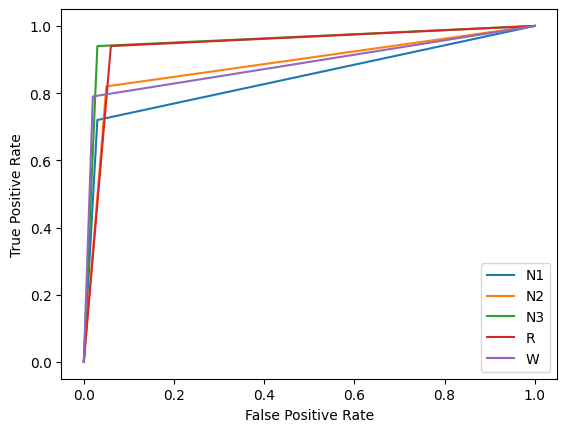

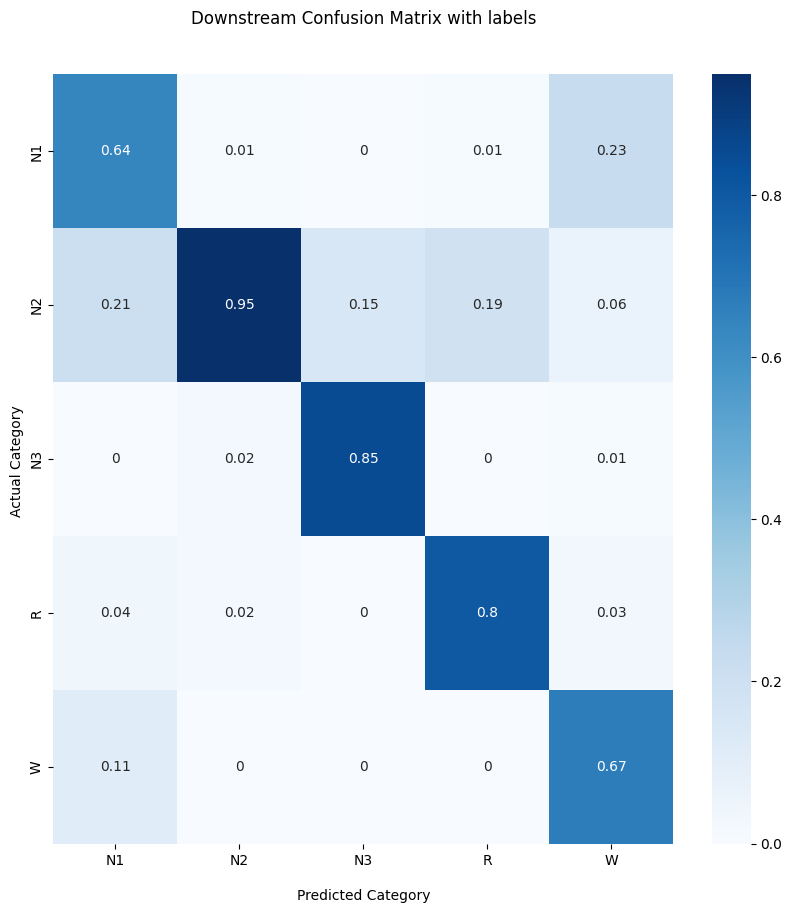

([0.64, 0.95, 0.85, 0.8, 0.67], 0.85)

In [21]:
import statistics as st

y_pred = np.zeros(psgs_test.shape[0])
for i in range(psgs_test.shape[0]):
  vals = np.zeros(10)
  vals[0] = np.argmax(y_preds[:, i, 0], axis=0)
  vals[1] = np.argmax(y_preds_2[:, i, 0], axis=0)
  vals[2] = np.argmax(y_preds_3[:, i, 0], axis=0)
  vals[3] = np.argmax(y_preds_4[:, i, 0], axis=0)
  vals[4] = np.argmax(y_preds_5[:, i, 0], axis=0)
  vals[5] = np.argmax(y_preds_6[:, i, 0], axis=0)
  vals[6] = np.argmax(y_preds_7[:, i, 0], axis=0)
  vals[7] = np.argmax(y_preds_8[:, i, 0], axis=0)
  vals[8] = np.argmax(y_preds_9[:, i, 0], axis=0)
  vals[9] = np.argmax(y_preds_10[:, i, 0], axis=0)
  y_pred[i] = np.floor(st.mode(vals))
Labels = ['N1','N2', 'N3', 'R', 'W']
printConfusionMatrix(all_labels_test, y_pred, Labels, show=True)